In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "potato_dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_nms=dataset.class_names

In [5]:
class_nms

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset) #it will give the size of a single batch approximately

68

In [7]:
68*32

2176

In [8]:
for image_batch,labels_batch in dataset.take(1): #take(1) will create a new ds with the first batch
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 1 0 1 0 1 1 1 1 0 1 2 0 0 1 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0]


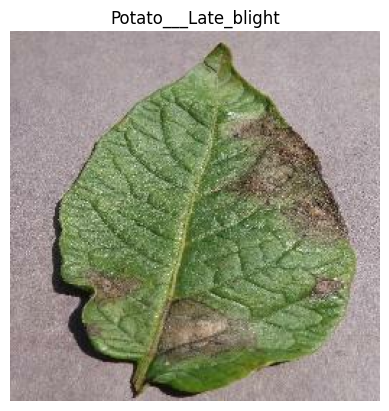

In [9]:
for image_batch,labels_batch in dataset.take(1):
    for i in range(12):
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_nms[labels_batch[i]])
        plt.axis('off')

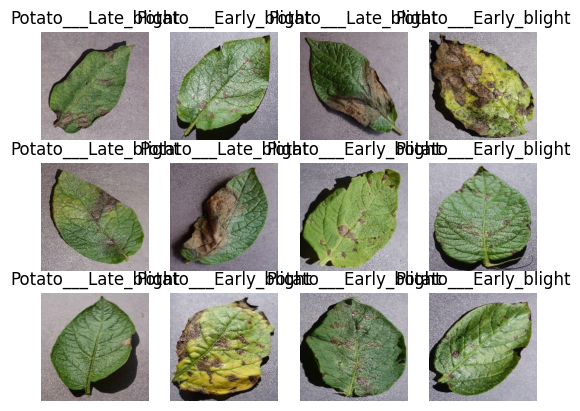

In [10]:
for image_batch,labels_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_nms[labels_batch[i]])
        plt.axis('off')

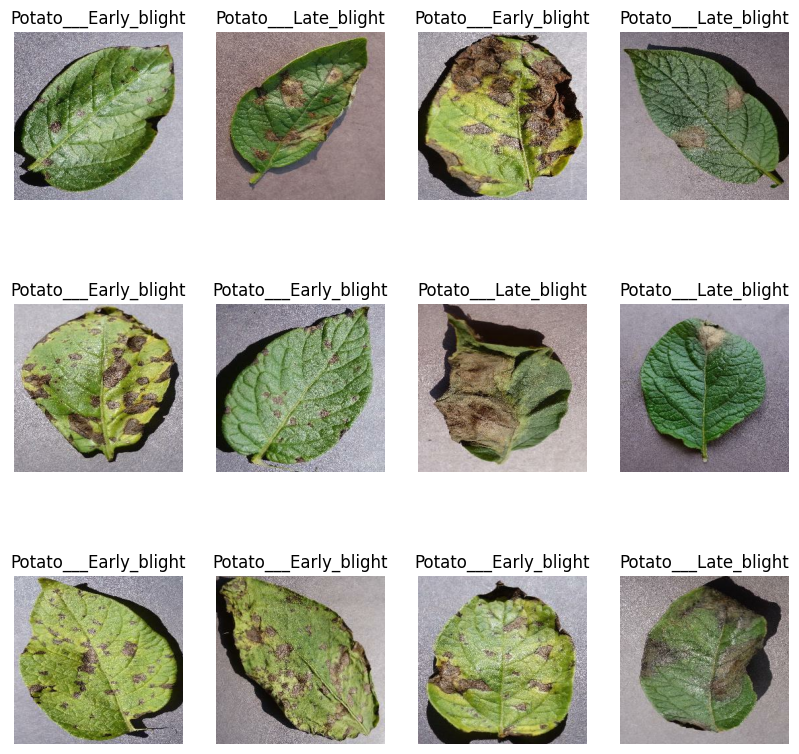

In [11]:
plt.figure(figsize=(10,10))
for image_batch,labels_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_nms[labels_batch[i]])
        plt.axis('off')

In [ ]:
# Train - Test

In [ ]:
80% => training
20% => test ( validation 10% + test 10%)

In [12]:
len(dataset)

68

In [13]:
#train 80
train_size=.8
len(dataset)*train_size

54.400000000000006

In [14]:
#so train ds
train_ds=dataset.take(54)
len(train_ds)

54

In [15]:
#so we need to split the index from 54 to 64 as test .2
test_ds=dataset.skip(54)  #like dataset[54:]

In [16]:
len(test_ds)

14

In [17]:
#validation ds is used when training
val_size=.1
len(dataset)*val_size

6.800000000000001

In [18]:
# so 
val_ds=test_ds.take(6)
len(val_ds)

6

In [19]:
#now actual test ds
test_ds=test_ds.skip(6)
len(test_ds)

8

In [20]:
def get_dataset_partitions_tf(ds,train_split=.8,val_split=.1,test_split=.1,shuffle=True,shuffle_size=10000):
 
    ds_size=len(ds)

    if shuffle: #shuffle before split
        ds = ds.shuffle(shuffle_size,seed=12) #seed to prevent same prediction output
    
    train_size=int(ds_size*train_split)
    val_size=int(ds_size*val_split)

    train_ds=ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [21]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [22]:
print(len(train_ds),len(val_ds),len(test_ds))

54 6 8


In [23]:
#cache: read the image from the disk and when u need that another time it will keep that in the memory
#prefetch : if gpu is busy in training the prefetch will load next set of batch from ur disk
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
#scale
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1.0/255)
])

In [25]:
#data augmentation if you train with correct angle image but u r inputing rotated or angle different image
#in that situation model mightbe predict wrong
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal and vertical"),
    layers.RandomRotation(.2), #.2 = 20% of 360
])

In [ ]:
# CNN

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 481ms/step - accuracy: 0.4517 - loss: 0.9455 - val_accuracy: 0.6771 - val_loss: 0.7076
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 458ms/step - accuracy: 0.7522 - loss: 0.6144 - val_accuracy: 0.7396 - val_loss: 0.5843
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 458ms/step - accuracy: 0.7982 - loss: 0.4299 - val_accuracy: 0.8438 - val_loss: 0.3345
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.8857 - loss: 0.3028 - val_accuracy: 0.9219 - val_loss: 0.2232
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 460ms/step - accuracy: 0.9112 - loss: 0.2285 - val_accuracy: 0.9271 - val_loss: 0.1830
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 460ms/step - accuracy: 0.9136 - loss: 0.2427 - val_accuracy: 0.9583 - val_loss: 0.1338
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 490ms/step - accuracy: 0.9170 - loss: 0.2038 - val_accuracy: 0.9323 - val_loss: 0.1882
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 489ms/step - accuracy: 0.9305 - loss: 0.1751 - val_accu

In [30]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9749 - loss: 0.0485


In [31]:
scores

[0.04987156391143799, 0.9765625]

In [32]:
#learn
#to know the index of max in a list
#np.argmax(lsit)

first image to predict
actual label: Potato___Late_blight


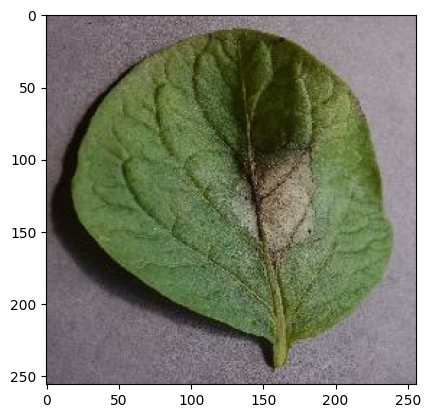

In [33]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_nms[first_label])

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
[7.6707564e-11 9.6730554e-01 3.2694418e-02]


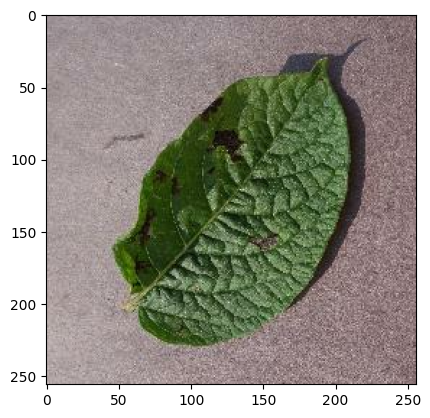

In [34]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_nms[first_label])

    batch_prediction = model.predict(images_batch) # this is the prediction for 32 images in a batch
    print(batch_prediction[0])

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
predicted label:  Potato___Early_blight  Label_accurecy:  [9.9804097e-01 1.9589991e-03 9.7158726e-09]


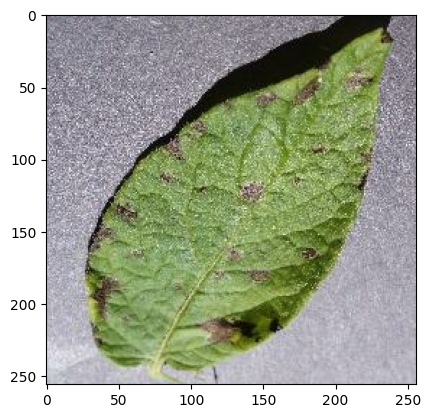

In [35]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_nms[first_label])

    batch_prediction = model.predict(images_batch) # this is the prediction for 32 images in a batch
    print("predicted label: ",class_nms[np.argmax(batch_prediction[0])]," Label_accurecy: ",batch_prediction[0])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_nms[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


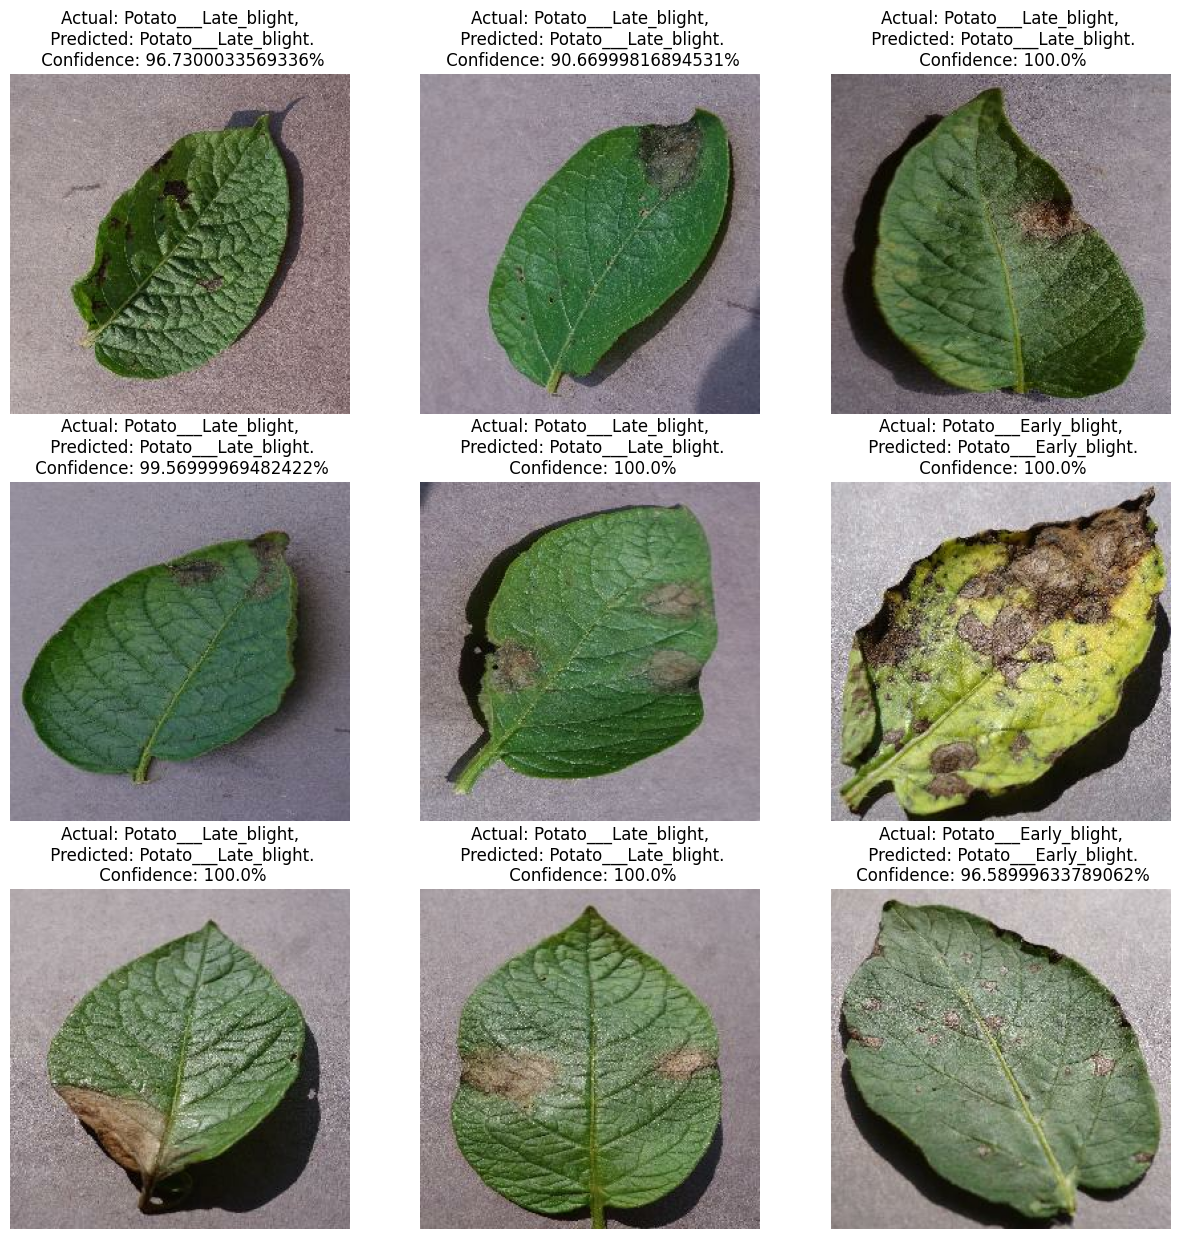

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_nms[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [38]:
model_version = 1
model.save(f"./saved_models/{model_version}")

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=./saved_models/1.

In [39]:
model_version = 1
model.save(f"./models/{model_version}.h5")